<h1>Audio Chord Estimation using Neural Networks</h1>
<h4>Theofanis Aslanidis</h4>
    

1. Load Datasets
    <br>1.1 We need to load our annotated data
    <br>1.2 We need to load the music for our data
2. Create Spectograms for our audio files

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
import re
import os

Get all chordlab files and store them in a dictionary of dataframes

In [2]:
### get all chordlab files
Chordlab = {'The Beatles': {}}
for filename in Path('Test-Dataset/The Beatles').glob('**/chordlab/**/*.lab'):
    
    path, track = os.path.split(filename)
    path, album = os.path.split(path)
    track_no = re.search('([0-9].)_-_',track).group(1)
    
    if (album not in Chordlab['The Beatles']): 
        Chordlab['The Beatles'][album] = {}
        
    Chordlab['The Beatles'][album][track_no] = pd.read_csv(filename, names=['Starts', 'Ends', 'Chord'], sep=' ', header=None)

Doing the same for the audio files -> Spectrogram

/home/fanarosss/Programms/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


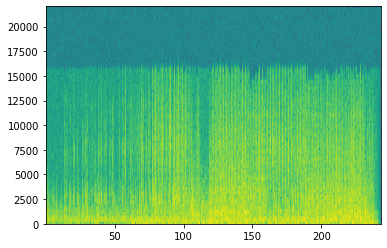

In [7]:
### get all audio files and create spectrogram for each track
Spectrograms = {'The Beatles': {}}
for filename in Path('Test-Audiofiles/The Beatles').glob('**/wav/*.wav'):
    
    path, track = os.path.split(filename)
    path, wav = os.path.split(path)
    path, album = os.path.split(path)
    
    track_no = re.search('([0-9].).',track).group(1)
    
    ### read wav and create spectogram
    sample_rate, samples = wavfile.read(filename)
    powerSpectrum, frequencies, times, imageAxis = plt.specgram(samples, Fs=sample_rate)
    
    if (album not in Spectrograms['The Beatles']): 
        Spectrograms['The Beatles'][album] = {}
        
    Spectrograms['The Beatles'][album][track_no] = {'powerSpectrum' : powerSpectrum, 
                                                    'frequencies' : frequencies, 
                                                    'times' : times}

<h4>Script to Convert mp3 files to wav</h4>

In [4]:
from pydub import AudioSegment
### get all audio files and create spectrogram for each track
for filename in Path('Audiofiles/The Beatles').glob('**/mp3/*.mp3'):
    # files
    path, track = os.path.split(filename)
    dst = re.sub(r'mp3', 'wav/', path) + re.sub(r'mp3', 'wav', track)
    # convert wav to mp3                                                            
    sound = AudioSegment.from_mp3(filename)
    #optional line if you want them in mono
    sound = sound.set_channels(1)
    sound.export(dst, format="wav")

<h4>Script to Convert files from stereo to mono</h4>

In [81]:
for filename in Path('Audiofiles/The Beatles').glob('**/wav/*.wav'):
    # convert stereo to mono                                                            
    sound = AudioSegment.from_wav(filename)
    sound = sound.set_channels(1)
    sound.export(filename, format="wav")

In [40]:
### get all audio files
path = 'Audiofiles/The Beatles/12_-_Let_It_Be/wav/06.Let It Be (Remastered 2009).wav'

Read files and create spectrogram

In [41]:
### read wav and create spectogram
sample_rate, samples = wavfile.read(path)

#frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

Plot spectrogram

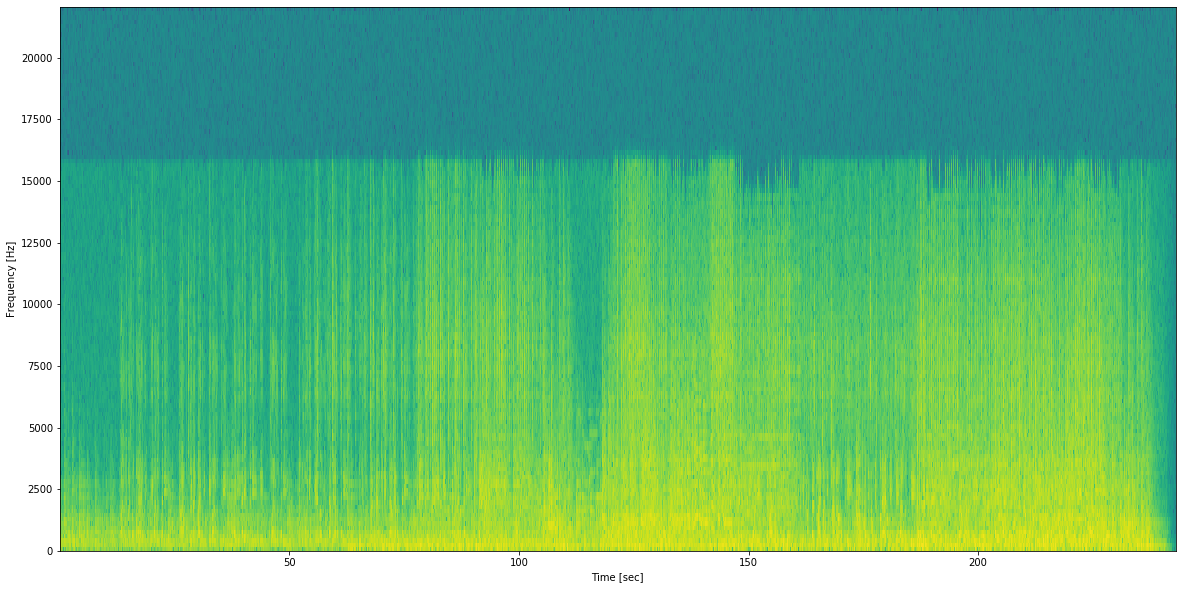

In [42]:
### plot spectogram

plt.figure(figsize=(20,10))
#plt.pcolormesh(times, frequencies, 10*np.log10(spectrogram))
powerSpectrum, frequencies, times, imageAxis = plt.specgram(samples, Fs=sample_rate)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

Now!
1. For training we should have all anotations, together with their spectrograms'
2. For testing all the spectrograms of the test dataset

<br>
<br>
X_train, Y_train = [spectrograms], [annotations]
<br>
X_test = [spectrograms_test]
<br><br>
<h3>Convert my data from dictionaries into data that I can feed in the neural network</h3>
Firstly, I'm thinking I have to create a vocabulary for the chords.<br>
Such as the <b>word2vec</b> representation we use on NLP, we will need in this project something similar.<br>
<b>Chord:</b><br>
C -> 0<br>
C#\Db -> 1<br>
D -> 2<br>
D#\Eb -> 3<br>
E -> 4<br>
F -> 5<br>
F#\Gb -> 6<br>
etc.<br>
<br>
<b>Mode:</b>
Minor Chord: 0<br>
Major Chord: 1<br>
<br>
<b>Sustained: </b>
1,2,3,4,5,6,7,8,9<br>

As it seems, the combinations can vary.<br>
So we can:
<ul>
    <li>try an encoding(hashing) for each chord, and when we stumble upon each chord we hash it to a unique combination that goes into a vector.</li>
    <li>we can iterate all train data, and for each chord we see, create a "slot" in our dictionary. So we have a dictionary with all the chords that appear on the dataset. That way we can work with a <b>one hot</b> representation.</li>
 </ul>

In [5]:
### Load all chords in a dictionary
Chords = []
for album in Chordlab['The Beatles'].keys():
    for track_no in Chordlab['The Beatles'][album].keys():
        for index, row in Chordlab['The Beatles'][album][track_no].iterrows():
            if row['Chord'] not in Chords: Chords.append(row['Chord'])
                
### How many chords do we have in our dataset?
print ("Unique Chords in our Dataset: ",len(Chords))

Unique Chords in our Dataset:  68


407 Chords, so our vectors are going to be <b>one hot vectors</b> of 407 size. (406 zeros and 1 one)

In [64]:
num_chords = len(Chords)
s = pd.Series(Chords)
OneHotEncodings = pd.get_dummies(s)

Now we have to align the <b>timing of the chords</b> with the <b>times array</b><br>
To achieve that lets try to convert the timing - chords data of the .lab files in the same representation as the spectrograms data.<br>
We will keep the same timeline (times), and using the timing 

In [11]:
chords2vec = {}
for album in Spectrograms['The Beatles'].keys():
    chords2vec[album] = {}
    for track_no in Spectrograms['The Beatles'][album].keys():
        print ('track ', track_no)
        times = Spectrograms['The Beatles'][album][track_no]['times']
        vector = np.empty((num_chords,))
        df_rows = Chordlab['The Beatles'][album][track_no].itertuples()
        index = 0
        max_len = len(Chordlab['The Beatles'][album][track_no])
        row = next(df_rows)
        for timestamp in times:
            if ((index + 1) < max_len) & (timestamp >= row[2]):
                print (row[1])
                index += 1
                row = next(df_rows)
            vector = np.column_stack((vector, OneHotEncodings[row[3]]))
        print (np.shape(vector))        
        chords2vec[album][track_no] = vector

track  03
0.0
0.403805
1.981768
3.560725
6.788299
10.050702000000001
11.652878999999999
13.197006
16.35492
19.501224
21.925720000000002
23.471836
25.062403
26.676190000000002
29.834103999999996
31.447891
34.617414000000004
41.037732
44.311746
50.551398
53.715827000000004
56.862131000000005
63.24456
66.40391600000001
69.482176
71.026303
72.55882
75.705124
78.897868
80.421672
81.986122
83.565079
85.120816
88.27873000000001
91.436643
94.59090400000001
95.407256
101.757913
104.973877
111.30131499999999
114.424399
117.52426299999999
123.77043
126.916734
129.981768
131.549115
133.093242
136.135056
137.72562299999998
140.790657
142.31156399999998
143.925351
146.990385
150.07863899999998
151.61248999999998
153.201723
159.52916000000002
162.687074
168.875192
171.963446
175.09814
181.286258
184.490612
187.451156
(407, 78633)
track  07
0.0
0.344657
3.117845
5.79975
11.337709
14.158934
17.003378
19.847823
21.26424
22.680657
25.583151
28.497256
34.197755
(407, 13815)
track  10
0.0
0.382952
3.738435

5.0502720000000005
9.230853
10.611450999999999
12.004648
14.849092
16.24229
17.670317
20.503151000000003
26.56356
29.605373999999998
31.045011
34.237755
35.758662
37.337619000000004
40.507142
46.81136
50.004104
51.397301
54.613265000000006
56.134172
57.713129
60.731722999999995
62.26424
63.819977
66.710861
68.115668
69.624965
74.696536
76.285788
82.52365
85.60029399999999
87.121201
90.290725
91.82324200000001
93.413809
96.513673
102.82950100000001
105.940975
107.437246
110.608185
112.175532
113.71965900000001
116.74986299999999
118.29399
119.872947
122.76383200000001
124.19185900000001
125.67793600000002
132.21435300000002
138.286371
141.374625
142.895532
145.972176
147.46986299999998
148.968415
151.974535
158.127823
161.262517
162.783424
165.88328700000002
167.404195
168.994761
172.071405
178.375623
181.661247
183.166049
186.386507
187.930634
189.599646
192.621065
194.176802
195.744149
198.716303
200.15594099999998
201.642018
206.700168
208.190045
209.641292
211.057709
213.97181400000

Now we have our 4D data ready in a dictionary to go into our model for training.<br>
3 dimensions (times, frequencies, power) will go as X_train and chords2vec will go as Y_train<br><br>
Store - Load Data with pickle

In [8]:
np.shape(Spectrograms['The Beatles']['12_-_Let_It_Be']['04']['powerSpectrum'])

(129, 50255)

In [14]:
### STORE
import pickle

with open('let_it_Be.pickle', 'wb') as handle:
    pickle.dump(chords2vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
### LOAD
import pickle

with open('let_it_Be.pickle', 'rb') as handle:
    chords2vec = pickle.load(handle)

In this article the following is stated.<br>
https://tm3.ghost.io/2018/09/05/building-lstms-for-time-series-forecasting/<br>
<i>"Instead of one sequence of 1870, you could have many sequences of let's say 20. Your sequences should be overlapping windows `[0-20], [1-21], [2-22]`, etc, so your final shape would be something like `(1850, 20, 14)`.Same process for your test data. Break into subsequences of the same length as training. You will have to play around with finding what a good subsequence length is. It is extremely important to have many different ways of slicing your data. If you train on just one super long sequence it will probably not learn anything interesting."</i>

TensorFlow model

In [4]:
import tensorflow as tf
from tensorflow import keras

Let's define first an RNN with tensorflow

In [92]:
def RNN(layers, shape):
    
    model = tf.keras.models.Sequential()
    
    model.add(keras.layers.LSTM(layers, input_shape=(129,1))) #my data input size
    
    #model.add(keras.layers.Flatten(input_shape=(129, 50255)))
    model.add(keras.layers.Dense(407, activation='softmax'))
    return model

In [83]:
y_train = chords2vec['12_-_Let_It_Be']['04']
x_train = Spectrograms['The Beatles']['12_-_Let_It_Be']['04']['powerSpectrum']

y_test = chords2vec['12_-_Let_It_Be']['05']
x_test = Spectrograms['The Beatles']['12_-_Let_It_Be']['05']['powerSpectrum']

In [95]:
x_train = np.resize(x_train, (50255, 129, 1))
y_train = np.resize(y_train, (50255, 407, 1))
x_test = np.resize(x_test, (50255, 129, 1))
y_test = np.resize(y_test, (50255, 407, 1))

We have to make all vectors <b>same shape.</b><br>
Set All to: <b>Max Times Vector Size -></b> those who have less timestamps, <b>get [0,0,0...0] on the chord2vec</b> for those timestamps

In [97]:
epochs = 5

model = RNN(30, x_train.shape)

model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train
model.fit(x_train, y_train, epochs=epochs,
          validation_data=(x_test, y_test), verbose=1)



Train on 50255 samples, validate on 50255 samples
Epoch 1/5
50255/50255 [==============================] - 36s 720us/sample - loss: 0.6944 - accuracy: 0.9975 - val_loss: 0.6944 - val_accuracy: 0.9974
Epoch 2/5
50255/50255 [==============================] - 35s 692us/sample - loss: 0.6944 - accuracy: 0.9975 - val_loss: 0.6944 - val_accuracy: 0.9974
Epoch 3/5
50255/50255 [==============================] - 35s 694us/sample - loss: 0.6944 - accuracy: 0.9975 - val_loss: 0.6944 - val_accuracy: 0.9974
Epoch 4/5
50255/50255 [==============================] - 35s 694us/sample - loss: 0.6944 - accuracy: 0.9975 - val_loss: 0.6944 - val_accuracy: 0.9974
Epoch 5/5
50255/50255 [==============================] - 35s 692us/sample - loss: 0.6944 - accuracy: 0.9975 - val_loss: 0.6944 - val_accuracy: 0.9974


NameError: name 'batch_size' is not defined

In [98]:
# evaluate on test set
scores = model.evaluate(x_test, y_test, 1, verbose=1)
print("Final test loss and accuracy :", scores)

50255/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Final test loss and accuracy : [0.6943701350016447, 0.9974406]
